In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

set2_colors = plt.get_cmap("Set2").colors
plt.rcParams['pdf.fonttype'] = 42

In [2]:
# root directory where processed mutation data are stored
# if using the zenodo data, this should point to the location of the base zenodo directory 
data_dir = ""

# directory where the simulation data and table with clonal counts and polyclonal calls are saved
# defaults to path in repo relative to current WD
output_dir = "../../data/clonal_count_estimation/"

save_plots = False
# directory where you want to save pdf versions of the plots (only use if save_plots = TRUE)
plots_dir = ""

In [3]:
clonal_calls = pd.read_csv(output_dir+"clonal_SNVs_WES_WGS.csv", index_col=0)
combined_maf = pd.read_csv(data_dir+"HTAN_WGS_filtered_ppVAFs.maf", sep="\t")
clonal_calls = clonal_calls[clonal_calls["has_WGS"]]

/share/software/user/open/py-jupyter/1.0.0_py39/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (85,87,88,90) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
def compute_binomial_bayes_CI(successes, failures, width=0.95):
    upper_quantile = 1 - (1-width)/2
    lower_quantile = (1-width)/2
    lower, upper = stats.beta.ppf([lower_quantile, upper_quantile], 1+successes, 1+failures)
    return lower, upper

def compute_errorbars(binom_data):
    return compute_binomial_bayes_CI(np.sum(binom_data.astype("boolean")), np.sum(~binom_data.astype("boolean")))

def sample_to_patient(sample):
    if sample[0] == "A":
        patient = sample[:4]
    else:
        patient = sample[:1]
    return patient

In [5]:
benign_mono_color = np.array(set2_colors[1]) + np.array([0, 0.2, 0.2])
benign_poly_color = np.array(set2_colors[1]) - np.array([0, 0.2, 0.2])

dysplastic_mono_color = np.array(set2_colors[2]) + np.array([0.2, 0.2, 0.2])
dysplastic_poly_color = np.array(set2_colors[2]) - np.array([0.2, 0.2, 0.2])

In [6]:
sample_to_poly = dict(zip(clonal_calls.index, clonal_calls["is_poly"]))
combined_maf["is_poly"] = [sample_to_poly[x] for x in combined_maf["Tumor_Sample_Barcode"]]

driver_presence = pd.DataFrame({"patient":clonal_calls["patient"].to_list(), "is_poly":clonal_calls["is_poly"].to_list(), "stage":clonal_calls["stage"].to_list(), "APC":[False]*len(clonal_calls), "KRAS":[False]*len(clonal_calls), "APC_multi":[False]*len(clonal_calls), "APC_unique":[True]*len(clonal_calls)}, index=clonal_calls.index)

APC_only = combined_maf[np.logical_and(combined_maf["Hugo_Symbol"]=="APC", combined_maf["Driver"])]
for sample in driver_presence.index:
    sample_only = combined_maf[combined_maf["Tumor_Sample_Barcode"]==sample]
    APC = sample_only[sample_only["Hugo_Symbol"] == "APC"]
    APC = APC[APC["Driver"]]
    #print(len(APC))
    if len(APC) >= 1:
        other_APC = APC_only[np.logical_and(APC_only["Patient"]==sample_to_patient(sample), APC_only["Tumor_Sample_Barcode"] != sample)]
        for mut in APC["Mut_ID"]:
            if mut in other_APC["Mut_ID"].tolist():
                driver_presence["APC_unique"].loc[sample] = False
        driver_presence["APC"].loc[sample] = True
    if len(APC) > 1:
        driver_presence["APC_multi"].loc[sample] = True
        
    KRAS = sample_only[sample_only["Hugo_Symbol"] == "KRAS"]
    KRAS = KRAS[KRAS["Driver"]]
    if len(KRAS) >= 1:
        driver_presence["KRAS"].loc[sample] = True
    
driver_presence["plot_cat"] = ["normal" if driver_presence.iloc[i]["stage"] == "Mucosa" else driver_presence.iloc[i]["stage"]+"_"+str(driver_presence.iloc[i]["is_poly"]) for i in range(len(driver_presence))]

new_labels = ["Normal\nmucosa", "Benign\npolyclonal", "Benign\nmonoclonal", "Dysplasia\npolyclonal", "Dysplasia\nmonoclonal"]
relabel_ticks = dict(zip(["normal", "Benign_True", "Benign_False", "Dysplasia_True", "Dysplasia_False"], new_labels))
driver_presence["plot_cat"] = [relabel_ticks[x] if x in relabel_ticks else x for x in driver_presence["plot_cat"]]

/share/software/user/open/py-pandas/1.3.1_py39/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


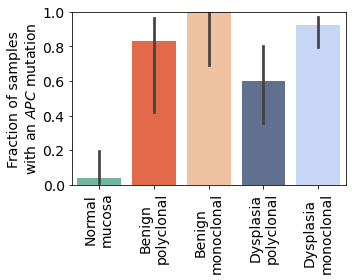

In [7]:
# FIGURE 3a

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
sns.barplot(x=driver_presence["plot_cat"], y=driver_presence["APC"], order=new_labels, palette=[set2_colors[0], benign_poly_color, benign_mono_color, dysplastic_poly_color, dysplastic_mono_color], errorbar=compute_errorbars)
plt.ylabel("Fraction of samples\nwith an $APC$ mutation", fontsize=14)
plt.xlabel("", fontsize=14)
plt.ylim(0,1)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14, rotation=90)
plt.tight_layout()
if save_plots:
    plt.savefig(plots_dir+"Fig3a_APCfreq_bystage_bar.pdf")
plt.show()

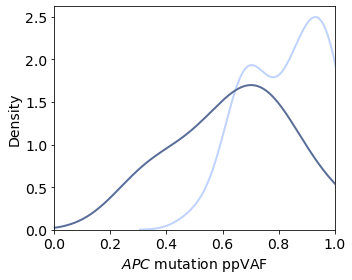

MannwhitneyuResult(statistic=103.0, pvalue=0.004634969249220088)


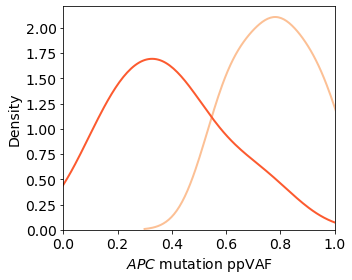

MannwhitneyuResult(statistic=3.0, pvalue=0.0027858431348979254)


In [8]:
# FIGURE 3b

to_plot = combined_maf[combined_maf["Stage"]=="Dysplasia"]
to_plot = to_plot[to_plot["Hugo_Symbol"] == "APC"]
to_plot = to_plot[to_plot["Driver"]]

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
sns.kdeplot(x=to_plot["ppVAF"], hue=to_plot["is_poly"], common_norm=False, ax=axs, legend=False, hue_order=[True, False], palette=[dysplastic_poly_color, dysplastic_mono_color], linewidth=2)
plt.xlim(0,1)
plt.xlabel("$APC$ mutation ppVAF", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
if save_plots:
    plt.savefig(plots_dir+"Fig3b_APCdist_dysplasia.pdf")
plt.show()

print(stats.mannwhitneyu(to_plot[to_plot["is_poly"]]["ppVAF"], to_plot[~to_plot["is_poly"]]["ppVAF"]))

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
to_plot = combined_maf[combined_maf["Stage"]=="Benign"]
to_plot = to_plot[to_plot["Hugo_Symbol"] == "APC"]
to_plot = to_plot[to_plot["Driver"]]

sns.kdeplot(x=to_plot["ppVAF"], hue=to_plot["is_poly"], common_norm=False, ax=axs, legend=False, hue_order=[True, False], palette=[benign_poly_color, benign_mono_color],  linewidth=2)
plt.xlim(0,1)
plt.xlabel("$APC$ mutation ppVAF", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
if save_plots:
    plt.savefig(plots_dir+"Fig3b_APCdist_benign.pdf")
plt.show()

print(stats.mannwhitneyu(to_plot[to_plot["is_poly"]]["ppVAF"], to_plot[~to_plot["is_poly"]]["ppVAF"]))

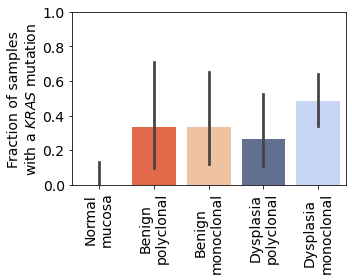

In [9]:
# FIGURE 3c

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
sns.barplot(x=driver_presence["plot_cat"], y=driver_presence["KRAS"], order=new_labels, palette=[set2_colors[0], benign_poly_color, benign_mono_color, dysplastic_poly_color, dysplastic_mono_color], errorbar=compute_errorbars)
plt.ylabel("Fraction of samples\nwith a $KRAS$ mutation", fontsize=14)
plt.xlabel("", fontsize=14)
plt.ylim(0,1)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14, rotation=90)
plt.tight_layout()
if save_plots:
    plt.savefig(plots_dir+"Fig3c_KRASfreq_bystage_bar.pdf")
plt.show()

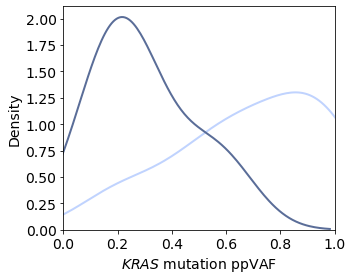

MannwhitneyuResult(statistic=11.0, pvalue=0.011831675068991142)


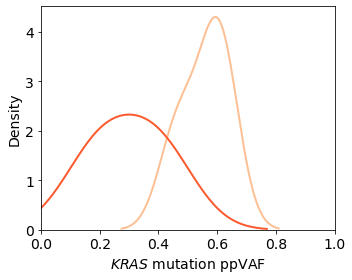

MannwhitneyuResult(statistic=0.0, pvalue=0.07445733658938286)


In [10]:
# FIGURE 3d

to_plot = combined_maf[combined_maf["Stage"]=="Dysplasia"]
to_plot = to_plot[to_plot["Hugo_Symbol"] == "KRAS"]
to_plot = to_plot[to_plot["Driver"]]

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
sns.kdeplot(x=to_plot["ppVAF"], hue=to_plot["is_poly"], common_norm=False, ax=axs, legend=False, hue_order=[True, False], palette=[dysplastic_poly_color, dysplastic_mono_color], linewidth=2)
plt.xlim(0,1)
plt.xlabel("$KRAS$ mutation ppVAF", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
if save_plots:
    plt.savefig(plots_dir+"Fig3d_KRASdist_dysplasia.pdf")
plt.show()

print(stats.mannwhitneyu(to_plot[to_plot["is_poly"]]["ppVAF"], to_plot[~to_plot["is_poly"]]["ppVAF"]))

to_plot = combined_maf[combined_maf["Stage"]=="Benign"]
to_plot = to_plot[to_plot["Hugo_Symbol"] == "KRAS"]
to_plot = to_plot[to_plot["Driver"]]

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
sns.kdeplot(x=to_plot["ppVAF"], hue=to_plot["is_poly"], common_norm=False, ax=axs, legend=False, hue_order=[True, False], palette=[benign_poly_color, benign_mono_color],  linewidth=2, warn_singular=False)
#poly_only = to_plot[to_plot["is_poly"]].iloc[0]["purity_ccf"]
#plt.axvline(x=poly_only, color=benign_poly_color)
plt.xlim(0,1)
plt.xlabel("$KRAS$ mutation ppVAF", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
if save_plots:
    plt.savefig(plots_dir+"Fig3d_KRASdist_benign.pdf")
plt.show()

print(stats.mannwhitneyu(to_plot[to_plot["is_poly"]]["ppVAF"], to_plot[~to_plot["is_poly"]]["ppVAF"]))